<a href="https://colab.research.google.com/github/gitHubAndyLee2020/Celeb_Face_Generator/blob/main/celeb_face_generator_diffusion_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Celeb Face Generator using U-Net Diffusion Model
- 32x32 image
- Trained for 2 epochs on 10,000 images

In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9hynz92d
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-9hynz92d
  Resolved https://github.com/tensorflow/docs to commit 2b700605aaf42a346624aaff5c84879999d4c407
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=8b173a083f891c8fb8fa8c340926bd8ed9a99662c7c856521d16f19deb12ab2d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tbha0c2e/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import os
import PIL
import time

from IPython import display

In [4]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving selected_images_10k.zip to selected_images_10k.zip
User uploaded file "selected_images_10k.zip" with length 69933417 bytes


In [22]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving celeb_face_generator_diffusion_v1_epochs_1.h5 to celeb_face_generator_diffusion_v1_epochs_1.h5
User uploaded file "celeb_face_generator_diffusion_v1_epochs_1.h5" with length 43408832 bytes


In [5]:
! unzip selected_images_10k.zip

Streaming output truncated to the last 5000 lines.
  inflating: selected_images/005001.jpg  
  inflating: selected_images/005002.jpg  
  inflating: selected_images/005003.jpg  
  inflating: selected_images/005004.jpg  
  inflating: selected_images/005005.jpg  
  inflating: selected_images/005006.jpg  
  inflating: selected_images/005007.jpg  
  inflating: selected_images/005008.jpg  
  inflating: selected_images/005009.jpg  
  inflating: selected_images/005010.jpg  
  inflating: selected_images/005011.jpg  
  inflating: selected_images/005012.jpg  
  inflating: selected_images/005013.jpg  
  inflating: selected_images/005014.jpg  
  inflating: selected_images/005015.jpg  
  inflating: selected_images/005016.jpg  
  inflating: selected_images/005017.jpg  
  inflating: selected_images/005018.jpg  
  inflating: selected_images/005019.jpg  
  inflating: selected_images/005020.jpg  
  inflating: selected_images/005021.jpg  
  inflating: selected_images/005022.jpg  
  inflating: selected_ima

In [6]:
import random
from PIL import Image

# Step 1: List all image files
folder_path = 'selected_images'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Step 2: Load images into a NumPy array
image_list = []
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    # Open the image and convert to RGB (to match CIFAR-10)
    image = Image.open(image_path).convert('RGB')

    # Resize the image to 32x32 to match the dimensions of CIFAR-10 dataset
    image = image.resize((32, 32))

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Add to the list of images
    image_list.append(image_array)

# Convert the list to a NumPy array
X_train = np.array(image_list)

# Step 3: Preprocess images
# Normalize the images to [-1, 1], similar to your "Previous Dataset"
X_train = (X_train / 127.5) - 1.0

In [44]:
def cvtImg(img):
  img = img - img.min()
  img = (img / img.max())
  return img.astype(np.float32)

def show_examples(x):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = cvtImg(x[i])
    plt.imshow(img)
    plt.axis('off')
  plt.savefig(f'/content/predict_epochs_{CURRENT_EPOCH}.png')

# show_examples(X_train)

In [45]:
IMG_SIZE = 32
BATCH_SIZE = 128
timesteps = 16
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

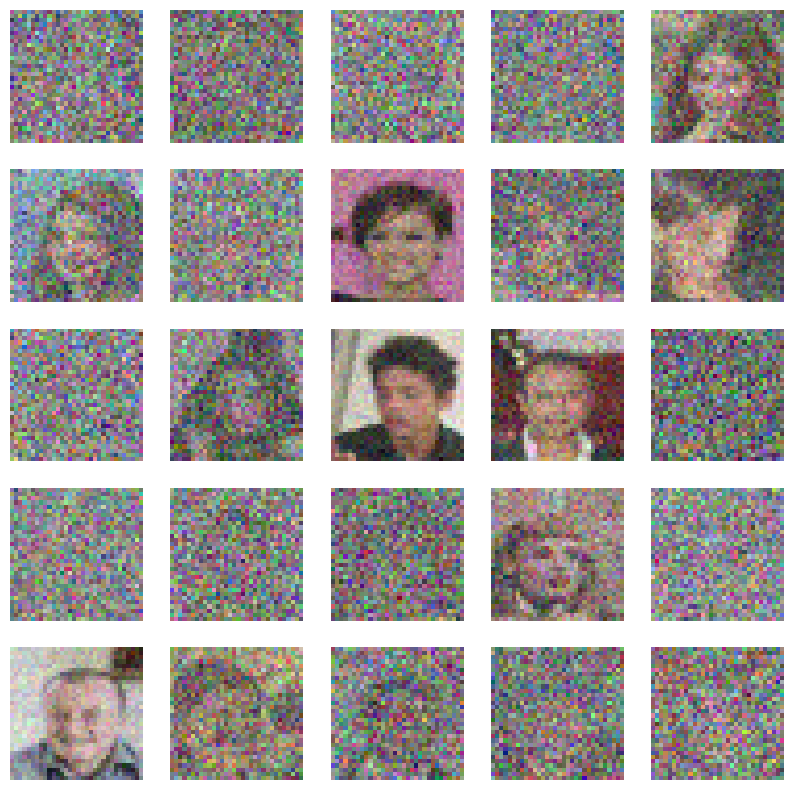

In [46]:
def forward_noise(x, t):
  a = time_bar[t]
  b = time_bar[t + 1]

  noise = np.random.normal(size=x.shape)
  a = a.reshape((-1, 1, 1, 1))
  b = b.reshape((-1, 1, 1, 1))
  img_a = x * (1 - a) + noise * a
  img_b = x * (1 - b) + noise * b
  return img_a, img_b

def generate_ts(num):
  return np.random.randint(0, timesteps, size=num)

t = generate_ts(25)
a, b = forward_noise(X_train[:25], t)
show_examples(a)

In [47]:
def block(x_img, x_ts):
  x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
  x_parameter = layers.Activation('relu')(x_parameter)

  time_parameter = layers.Dense(128)(x_ts)
  time_parameter = layers.Activation('relu')(time_parameter)
  time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
  x_parameter = x_parameter + time_parameter

  x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
  x_out = x_out + x_parameter
  x_out = layers.LayerNormalization()(x_out)
  x_out = layers.Activation('relu')(x_out)

  return x_out

In [48]:
def make_model():
  x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')

  x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
  x_ts = layers.Dense(192)(x_ts)
  x_ts = layers.LayerNormalization()(x_ts)
  x_ts = layers.Activation('relu')(x_ts)

  x = x32 = block(x, x_ts)
  x = layers.MaxPool2D(2)(x)

  x = x16 = block(x, x_ts)
  x = layers.MaxPool2D(2)(x)

  x = x8 = block(x, x_ts)
  x = layers.MaxPool2D(2)(x)

  x = x4 = block(x, x_ts)

  x = layers.Flatten()(x)
  x = layers.Concatenate()([x, x_ts])
  x = layers.Dense(128)(x)
  x = layers.LayerNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Dense(4 * 4 * 32)(x)
  x = layers.LayerNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Reshape((4, 4, 32))(x)

  x = layers.Concatenate()([x, x4])
  x = block(x, x_ts)
  x = layers.UpSampling2D(2)(x)

  x = layers.Concatenate()([x, x8])
  x = block(x, x_ts)
  x = layers.UpSampling2D(2)(x)

  x = layers.Concatenate()([x, x16])
  x = block(x, x_ts)
  x = layers.UpSampling2D(2)(x)

  x = layers.Concatenate()([x, x32])
  x = block(x, x_ts)

  x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
  model = tf.keras.models.Model([x_input, x_ts_input], x)
  return model

# model = make_model()

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

In [49]:
def predict(model, x_idx = None):
  x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
  for i in trange(timesteps):
    t = i
    x = model.predict([x, np.full((32), t)], verbose=0)
  show_examples(x)

# predict(model = loaded_model)

In [50]:
def predict_step(model):
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')
    plt.savefig(f'/content/predict_step_output_epochs_{CURRENT_EPOCH}.png')

# predict_step(model = loaded_model)

In [51]:
def train_one(model, x_img):
  x_ts = generate_ts(len(x_img))
  x_a, x_b = forward_noise(x_img, x_ts)
  loss = model.train_on_batch([x_a, x_ts], x_b)
  return loss

In [52]:
def train(model, R=50):
  bar = trange(R)
  total = 100
  for i in bar:
    for j in range(total):
      x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
      loss = train_one(model, x_img)
      pg = (j / total) * 100
      if j % 5 == 0:
        bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [42]:
NUM_EPOCHS = 1
PREVIOUS_EPOCH = 2
CURRENT_EPOCH = 3

In [43]:
loaded_model = tf.keras.models.load_model(f"celeb_face_generator_diffusion_v1_epochs_{PREVIOUS_EPOCH}.h5")

In [53]:
for _ in range(NUM_EPOCHS):
  train(model = loaded_model)

  loaded_model.optimizer.learning_rate = max(0.000001, loaded_model.optimizer.learning_rate * 0.9)

  predict(model = loaded_model)
  predict_step(model = loaded_model)
  plt.show()

  loaded_model.save(f"celeb_face_generator_diffusion_v1_epochs_{CURRENT_EPOCH}.h5")

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored